In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("incl/")


import narrom
import ELPH_utils

In [2]:

runs = ELPH_utils.load_runs(filename='/home/agluedge/Preprints/ELPH/runs/runs_n_kmax=200.npz')

# runs = runs[::10]
# for k in range(len(runs)):
#     runs[k] = runs[k][:,::2]

n_runs = len(runs)
n_kmax = runs[0].shape[0]

print(n_runs, 'loaded with n_kmax =', n_kmax)

1000 loaded with n_kmax = 200


runs[0] shape:  (200, 400)


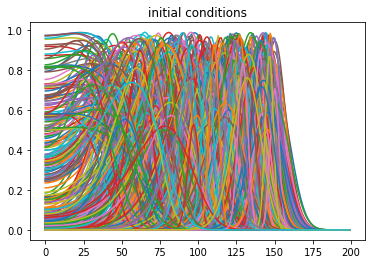

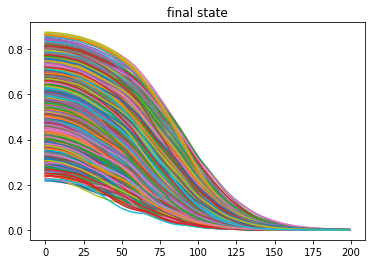

In [3]:
print('runs[0] shape: ', runs[0].shape)

for k in range(n_runs):
    plt.plot(runs[k][:,0])

plt.title('initial conditions')
plt.show()


for k in range(n_runs):
    plt.plot(runs[k][:,-1])

plt.title('final state')
plt.show()

full_hist:  False
intercept:  True
standardize:  True
rdim:  20
prdim:  20
n_VAR_steps:  2
train shape:  (861, 399000)
target shape:  (20, 399000)
weights shape:  (861, 20)


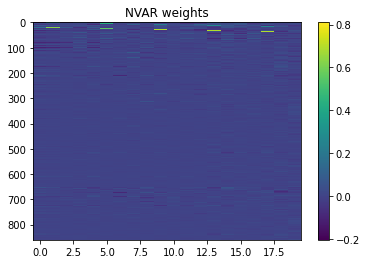

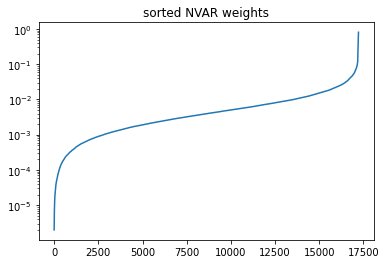

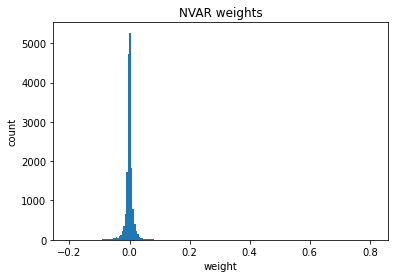

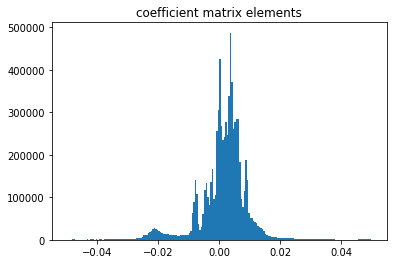

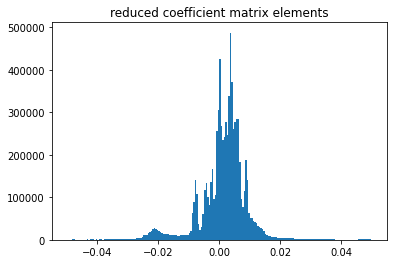

In [20]:
dim_reducer = narrom.dim_reducer.SVD()
scaler = narrom.scaler.normalize_scaler(0.1)
transformer = narrom.transformer.polynomial_features(order=2)
optimizer = narrom.optimizer.ridge(alpha=10.**-3.5)

model = narrom.narrom(runs, n_VAR_steps=2, intercept=True, full_hist=False, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=transformer)

model.train(rdim=20, prdim = 20)

model.print_status()


masked_weights = np.ma.masked_values(model.w,0.0)
plt.imshow(masked_weights, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('NVAR weights')
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(model.w))))
plt.title('sorted NVAR weights')
plt.show()

plt.hist(np.ravel(model.w), bins=200)
plt.title('NVAR weights')
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

plt.hist(np.ravel(model.coef_matrix), bins=200)
plt.title('coefficient matrix elements')
plt.show()

plt.hist(np.ravel(model.coef_matrix[:model.rdim]), bins=200)
plt.title('reduced coefficient matrix elements')
plt.show()

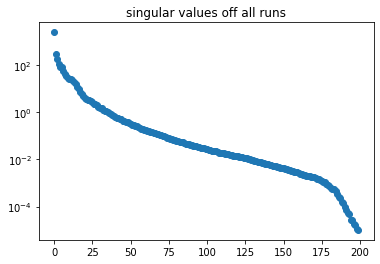

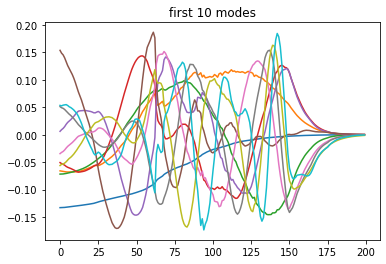

In [5]:
plt.semilogy(dim_reducer.S, 'o')
plt.title('singular values off all runs')
plt.show()

rdim = 10
for l in range(rdim):
  plt.plot(dim_reducer.U[:,l],  label='U_'+str(l))
plt.title('first ' + str(rdim) + ' modes')
plt.show()

In [13]:

test_run = ELPH_utils.load_runs(filename='/home/agluedge/Preprints/ELPH/example_run.npz')[0]
print('example run loaded with shape: ', test_run.shape)


example run loaded with shape:  (200, 400)


In [16]:
pred = model.predict_single_run(test_run)

print('std error: ', model.get_error(test_run, pred, norm='std') )
print('max error: ', model.get_error(test_run, pred, norm='max') )

std error:  0.0039347597594313315
max error:  0.09517082553297851


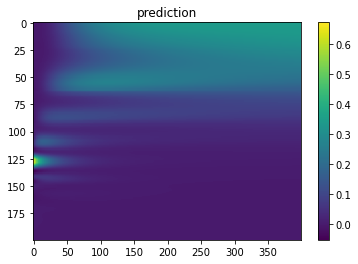

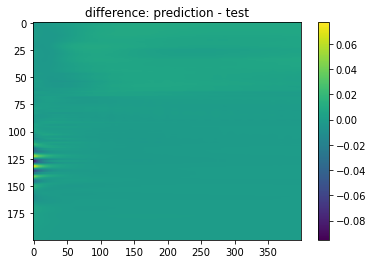

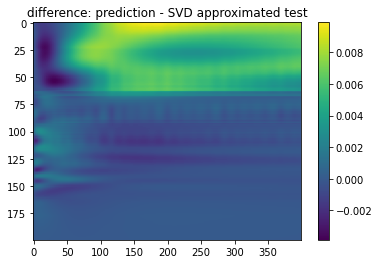

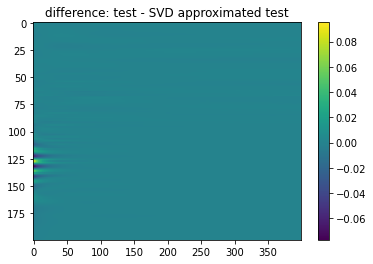

In [17]:
plt.imshow(pred, aspect='auto', interpolation='none')
plt.title('prediction')
plt.colorbar()
plt.show()

plt.imshow(pred-test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - test')
plt.show()


test_run_SVDapprx = dim_reducer.expand( dim_reducer.reduce(test_run,20) )

plt.imshow(pred-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - SVD approximated test')
plt.show()

plt.imshow(test_run-test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: test - SVD approximated test')
plt.show()



In [19]:
dim_reducer = narrom.dim_reducer.SVD()
scaler = narrom.scaler.normalize_scaler(0.1)
transformer = narrom.transformer.polynomial_features(order=2)
optimizer = narrom.optimizer.ridge(alpha=10.**-3.5)

model = narrom.narrom(runs, n_VAR_steps=2, intercept=True, full_hist=False, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=transformer)

train_kwargs = {'rdim':20, 'prdim':20}

scores = ELPH_utils.get_KFold_CV_scores(model, runs, folds=10, seed=817, norms=['std','max'], train_kwargs=train_kwargs)

print('std error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )

std error:  0.006301407495053643 +- 0.00393118079468427
max error:  0.03138361624470426 +- 0.022604387936276796


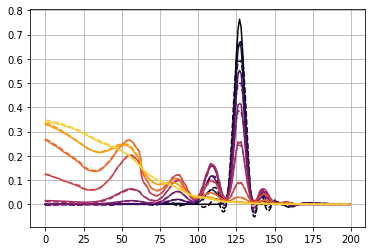

std error:  0.003235759206859351
max abs error:  0.09517082553297851


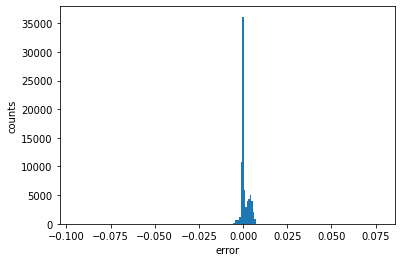

In [10]:
pl_colors = plt.get_cmap('inferno')

tn_arr = [0,2,5,10,20,50,100,200,399]

plt.grid()

for k,tn in enumerate(tn_arr):
    plt.plot(test_run[:,tn], '-', c=pl_colors(k/len(tn_arr)))
    plt.plot(pred[:,tn], '--', c=pl_colors(k/len(tn_arr)))

plt.show()

print('std error: ', model.get_error(test_run, pred, norm='std') )
print('max abs error: ', model.get_error(test_run, pred, norm='max') )

plt.hist(np.ravel(pred-test_run), bins = 200)
plt.xlabel('error')
plt.ylabel('counts')
plt.show()

full_hist:  False
intercept:  True
standardize:  True
rdim:  20
prdim:  20
n_VAR_steps:  2
train shape:  (861, 398601)
target shape:  (20, 398601)
weights shape:  (861, 20)
std error:  0.002969750732348964
max error:  0.013657223307129707


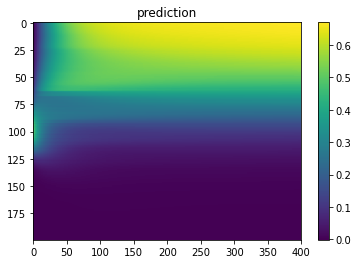

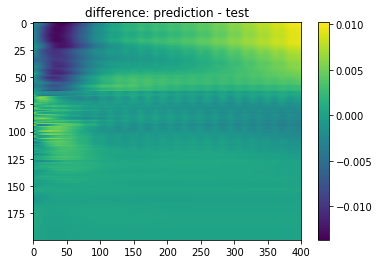

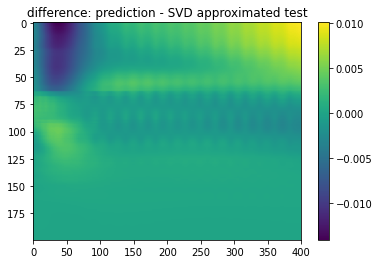

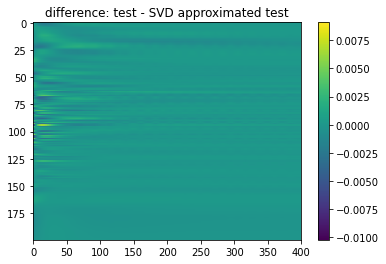

In [11]:
dim_reducer = narrom.dim_reducer.SVD()
scaler = narrom.scaler.normalize_scaler(0.1)
transformer = narrom.transformer.polynomial_features(order=2)
optimizer = narrom.optimizer.ridge(alpha=10.**-3.5)


train_runs = runs[::1]
popped_test_run = train_runs.pop(85)


model = narrom.narrom(train_runs, n_VAR_steps=2, intercept=True, full_hist=False, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=transformer)

model.train(rdim=20, prdim = 20)

model.print_status()

pred = model.predict_single_run(popped_test_run)

print('std error: ', model.get_error(popped_test_run, pred, norm='std') )
print('max error: ', model.get_error(popped_test_run, pred, norm='max') )



xmax = runs[0].shape[1]

plt.imshow(pred, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('prediction')
plt.xlim(0,xmax)
plt.show()

plt.imshow(pred-popped_test_run, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - test')
plt.xlim(0,xmax)
plt.show()


popped_test_run_SVDapprx = dim_reducer.expand( dim_reducer.reduce(popped_test_run,20) )

plt.imshow(pred-popped_test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: prediction - SVD approximated test')
plt.xlim(0,xmax)
plt.show()

plt.imshow(popped_test_run-popped_test_run_SVDapprx, aspect='auto', interpolation='none')
plt.colorbar()
plt.title('difference: test - SVD approximated test')
plt.xlim(0,xmax)
plt.show()
